In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/MyDrive/Colab Notebooks/project"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Your/A3/path/" $datadir # TODO: Fill your A3 path
os.chdir(datadir)

In [4]:
import torch.nn as nn
import torch

## DATA PRE-PROCESSING AND TRAIN-TEST SPLIT

In [7]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', input_size=(224, 224)):
        self.mode = mode
        self.input_size = input_size
        self.classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
        self.data = []
        if self.mode == 'train':
            for label, class_name in enumerate(self.classes):
                class_dir = os.path.join(data_dir, 'train', class_name)
                for img_file in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_file)
                    self.data.append((img_path, label))
        elif self.mode == 'val':
          for label, class_name in enumerate(self.classes):
              class_dir = os.path.join(data_dir, 'val', class_name)
              for img_file in os.listdir(class_dir):
                  img_path = os.path.join(class_dir, img_file)
                  self.data.append((img_path, label))
        else:
            test_dir = os.path.join(data_dir, 'test')
            for img_file in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_file)
                self.data.append((img_path, None))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = cv2.imread(img_path)
        if img is None:
            img = np.zeros((self.input_size[0], self.input_size[1], 3), dtype=np.uint8)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, self.input_size)
        img = (img.astype('float32') / 255.0 - 0.5) * 2.0
        img = np.transpose(img, (2, 0, 1))

        if label is not None:
            label = np.array(label)
        else:
          return torch.from_numpy(img)

        return torch.from_numpy(img), torch.from_numpy(label)

data_dir = '/content/drive/MyDrive/Colab Notebooks/project/imgs/'

# Define the input size of the images
input_size = (224, 224)
batch_size = 32

train_dataset = ImageDataset(data_dir, mode='train', input_size=input_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

val_dataset = ImageDataset(data_dir, mode='val', input_size=input_size)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = ImageDataset(data_dir, mode='test', input_size=input_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


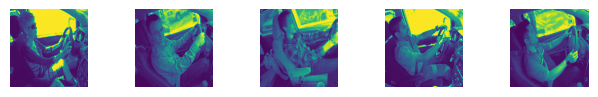

In [8]:
import matplotlib.pyplot as plt
random_samples = np.random.randint(1, len(train_dataset), (5))
for idx in range(random_samples.shape[0]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(train_dataset[idx][0][0].numpy())
    plt.axis('off')
plt.tight_layout()
plt.show()


## Define Autoencoder

1. Define and train the autoencoder

2. Extract encoded features
- pass your dataset through the encoder part of the autoencoder
- obtain the encoded features

3. Preprocess the encoded features
- preprocess the encoded features to match the expected input format of the DenseNet model

4. Feed the encoded features into DenseNet-121
- pass the preprocessed encoded features through the pre-trained DenseNet-121 model
- obtain the output predictions of the model based on the encoded features

In [23]:
from models.autoencoder import AI as autoencoder

In [24]:
autoencoder = autoencoder()

## Train AutoEncoder

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
autoencoder = autoencoder.to(device)

In [ ]:
batch_size = 32
num_epochs = 50

In [ ]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
train_loss = []
for epoch in range(num_epochs):
  # Set the autoencoder in training mode
  autoencoder.train()
  # variable for storing loss
  running_loss = 0
  
  # Iterate over the training dataset
  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Forward pass
      reconstructed_images = autoencoder(images)
      
      # Compute the loss
      loss = criterion(reconstructed_images, images)

      # Backward pass and optimization
      loss.backward()

      # Incrementing loss
      running_loss += loss.item()

      optimizer.step()
  
  running_loss = running_loss/len(train_loader)
  train_loss.append(running_loss)

  
  # Print the training loss for each epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0909
Epoch [2/10], Loss: 0.0830
Epoch [3/10], Loss: 0.0823
Epoch [4/10], Loss: 0.0684
Epoch [5/10], Loss: 0.0721
Epoch [6/10], Loss: 0.0661
Epoch [7/10], Loss: 0.0650
Epoch [8/10], Loss: 0.0696
Epoch [9/10], Loss: 0.0628
Epoch [10/10], Loss: 0.0603


In [ ]:
model_path = "autoencoder.pth"
torch.save(autoencoder.state_dict(), model_path)

In [ ]:
num_epochs = 40
for epoch in range(num_epochs):
  # Set the autoencoder in training mode
  autoencoder.train()
  # variable for storing loss
  running_loss = 0
  
  # Iterate over the training dataset
  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Forward pass
      reconstructed_images = autoencoder(images)
      
      # Compute the loss
      loss = criterion(reconstructed_images, images)

      # Backward pass and optimization
      loss.backward()

      # Incrementing loss
      running_loss += loss.item()

      optimizer.step()
  
  running_loss = running_loss/len(train_loader)
  train_loss.append(running_loss)

  
  # Print the training loss for each epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/40], Loss: 0.0644
Epoch [2/40], Loss: 0.0602
Epoch [3/40], Loss: 0.0600
Epoch [4/40], Loss: 0.0539
Epoch [5/40], Loss: 0.0589
Epoch [6/40], Loss: 0.0660
Epoch [7/40], Loss: 0.0547
Epoch [8/40], Loss: 0.0495
Epoch [9/40], Loss: 0.0550
Epoch [10/40], Loss: 0.0581
Epoch [11/40], Loss: 0.0549
Epoch [12/40], Loss: 0.0594
Epoch [13/40], Loss: 0.0577
Epoch [14/40], Loss: 0.0570
Epoch [15/40], Loss: 0.0564
Epoch [16/40], Loss: 0.0514
Epoch [17/40], Loss: 0.0625
Epoch [18/40], Loss: 0.0555
Epoch [19/40], Loss: 0.0481
Epoch [20/40], Loss: 0.0526
Epoch [21/40], Loss: 0.0538
Epoch [22/40], Loss: 0.0500
Epoch [23/40], Loss: 0.0584
Epoch [24/40], Loss: 0.0500
Epoch [25/40], Loss: 0.0553
Epoch [26/40], Loss: 0.0565
Epoch [27/40], Loss: 0.0490
Epoch [28/40], Loss: 0.0546
Epoch [29/40], Loss: 0.0582
Epoch [30/40], Loss: 0.0490
Epoch [31/40], Loss: 0.0483
Epoch [32/40], Loss: 0.0554
Epoch [33/40], Loss: 0.0476
Epoch [34/40], Loss: 0.0520
Epoch [35/40], Loss: 0.0516
Epoch [36/40], Loss: 0.0529
E

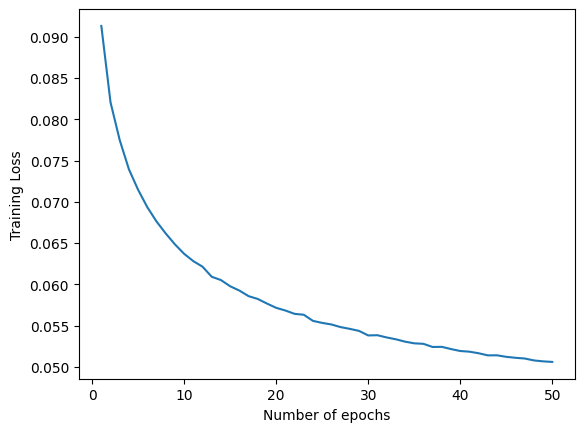

In [ ]:
# Plotting the training loss
num_epochs = 50
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

In [ ]:
# Set the autoencoder in evaluation mode
autoencoder.eval()

# Evaluate the autoencoder on the validation dataset
with torch.no_grad():
    total_loss = 0
    for images in val_loader:
        images = images.to(device)

        reconstructed_images = autoencoder(images)
        loss = criterion(reconstructed_images, images)
        total_loss += loss.item() * images.size(0)
    
    # Compute the average loss on the validation dataset
    average_loss = total_loss / len(val_loader)
    print(f"Average Validation Loss: {average_loss:.4f}")

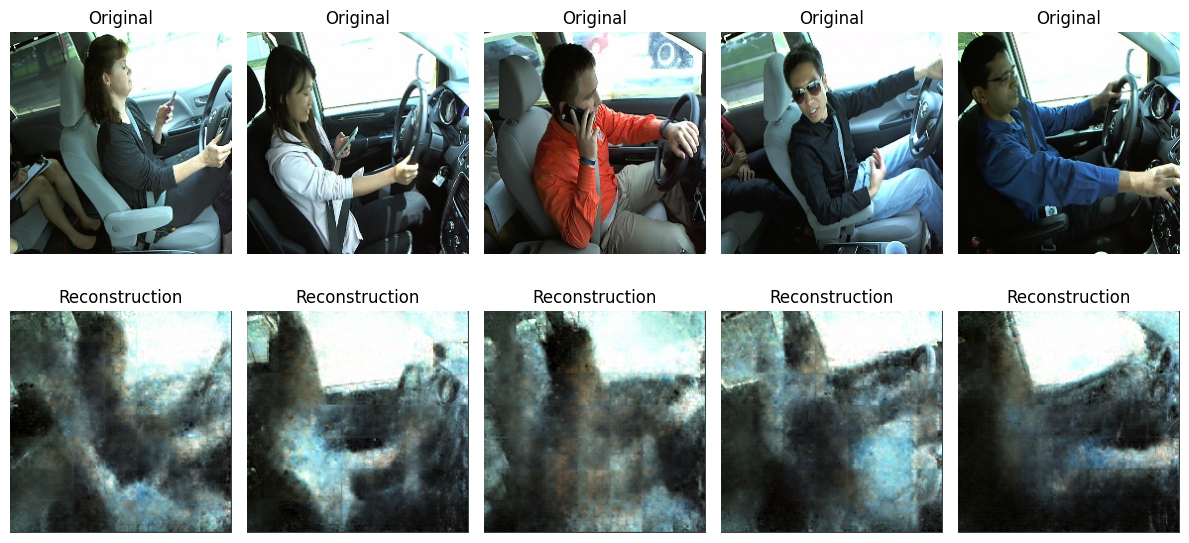

In [ ]:
import matplotlib.pyplot as plt
import cv2
autoencoder.eval()

# Get a batch of test images
images = next(iter(test_loader))
images = images.to(device)

# Generate reconstructed images
with torch.no_grad():
    reconstructed_images = autoencoder(images)

# Convert images to numpy arrays
images = images[:5].cpu().numpy()  # Select only the first 5 images
reconstructed_images = reconstructed_images[:5].cpu().numpy()  # Select reconstructions for the first 5 images

# Plot the original images and their reconstructions
num_images = 5
rows = 2
cols = num_images
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

for i in range(num_images):
    row = i // cols
    col = i % cols

    # Original image
    original_image = np.transpose(images[i], (1, 2, 0))
    original_image = (original_image + 1) / 2  # Denormalize

    # Reconstructed image
    reconstructed_image = np.transpose(reconstructed_images[i], (1, 2, 0))
    reconstructed_image = (reconstructed_image + 1) / 2  # Denormalize

    axes[row, col].imshow(original_image)  
    axes[row, col].axis('off')
    axes[row, col].set_title('Original')

    axes[row+1, col].imshow(reconstructed_image) 
    axes[row+1, col].axis('off')
    axes[row+1, col].set_title('Reconstruction')

plt.tight_layout()
plt.show()

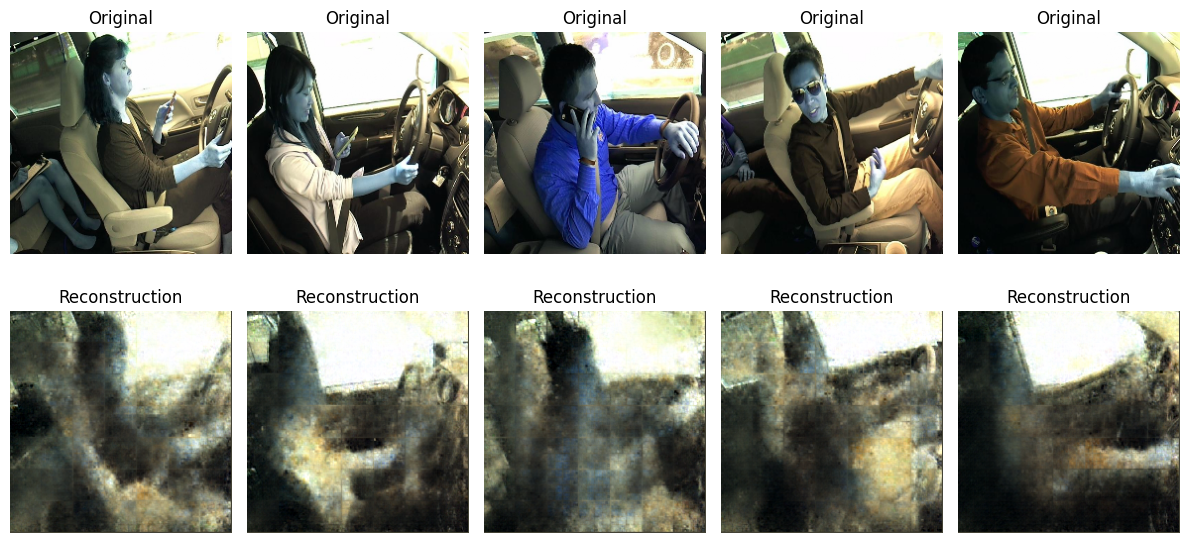

In [ ]:
# Plot the original images and their reconstructions
num_images = 5
rows = 2
cols = num_images
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i in range(num_images):
    row = i // cols ,b 
    col = i % cols

    # Original image
    original_image = np.transpose(images[i], (1, 2, 0))
    original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
    original_image = (original_image + 1) / 2  # Denormalize

    # Reconstructed image
    reconstructed_image = np.transpose(reconstructed_images[i], (1, 2, 0))
    reconstructed_image = cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR)
    reconstructed_image = (reconstructed_image + 1) / 2  # Denormalize

    axes[row, col].imshow(original_image)  
    axes[row, col].axis('off')
    axes[row, col].set_title('Original')

    axes[row+1, col].imshow(reconstructed_image) 
    axes[row+1, col].axis('off')
    axes[row+1, col].set_title('Reconstruction')

plt.tight_layout()
plt.show()



## LOAD PRETRAINED AUTOENCODER

In [ ]:
import torch
print(autoencoder)
autoencoder_path = "autoencoder.pth"
autoencoder.load_state_dict(torch.load(autoencoder_path))
autoencoder.eval()
autoencoder = autoencoder.to(device)

AI(
  (encoder): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): 

## Load pretrained Densenet Model


In [ ]:
from torchvision.models import densenet121

# replace the last fully connected layer of the model with a new one
densenet = densenet121(pretrained=True)
model_path = "densenet_classifier.pth"

# Modify the input requirements of the DenseNet model
densenet.features.transition3.pool = nn.AvgPool2d(kernel_size=6, stride=1)
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Sequential(
                      nn.Linear(num_ftrs, 10),
                      nn.Softmax(dim=1))



densenet.load_state_dict(torch.load(model_path))

densenet.eval()
densenet = densenet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## AUTOENCODER FOR CLASSIFICATION

In [ ]:
import torch
import torch.nn.functional as F

correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      encoded_images = autoencoder.encoder(images)
      encoded_images = F.interpolate(encoded_images, size=(224, 224), mode='bilinear', align_corners=False)
      outputs = densenet(encoded_images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

accuracy = 100 * correct/total
print("Classification Accuracy: {:.2f}%".format(accuracy))



Classification Accuracy: 10.33%


## Train Denset with the Autoencoder


In [42]:
from torchvision.models import densenet121
import torch.optim as optim

model = densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
# Create new Sequential module to append Softmax layer
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential( 
                      nn.Linear(num_ftrs, 10),
                      nn.Softmax(dim=1))

# freeze the parameters of the pre-trained layers

for param in model.classifier.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [44]:
import torch
import torch.nn.functional as F
autoencoder_path = "autoencoder.pth"
autoencoder.load_state_dict(torch.load(autoencoder_path))
autoencoder.eval()
autoencoder = autoencoder.to(device)

In [53]:
import time

def run_test(model, testloader, criterion):
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            encoded_images =  autoencoder.encoder(inputs)
            encoded_images = F.interpolate(encoded_images, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = model(encoded_images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()
    
    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)
    return val_loss, val_acc

In [50]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [54]:
def train(model, criterion, optimizer, num_epochs, decay_epochs, init_lr, start_epoch=0):
    model = model.to(device)
    for epoch in range(start_epoch, num_epochs + start_epoch):
      train_loss = 0.0
      train_acc = 0.0
      val_loss = 0.0
      val_acc = 0.0
      
      # train the model on the training data
      model.train()
      
      for i, (images, labels) in enumerate(train_loader, 0):
          images, labels = images.to(device), labels.to(device)
          adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
          encoded_images = autoencoder.encoder(images)
          encoded_images = F.interpolate(encoded_images, size=(224, 224), mode='bilinear', align_corners=False)
          outputs = model(encoded_images)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * images.size(0)
          train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()
          
      
      train_loss /= len(train_dataset)
      train_acc /= len(train_dataset)
      train_losses.append(train_loss)
      train_accs.append(train_acc)
  
      model.eval()
      val_loss, val_acc = run_test(model, val_loader, criterion)
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      print(f'Epoch {epoch+1}/{num_epochs + start_epoch}: '
          f'Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')
    return train_accs,train_losses,val_accs, val_losses

In [55]:
train_losses = []
train_accs = []
val_accs = []
val_losses = []
train(model, criterion, optimizer, num_epochs=5, decay_epochs=15, init_lr=1e-1)
model_path = 'densenet_autoencoder.pth'
torch.save(model.state_dict(), model_path)

Epoch 1/5: Training Loss: 2.0029, Training Acc: 0.5154, Validation Loss: 2.0492, Validation Acc: 0.5889
Epoch 2/5: Training Loss: 1.9721, Training Acc: 0.5424, Validation Loss: 2.0260, Validation Acc: 0.6007
Epoch 3/5: Training Loss: 1.9491, Training Acc: 0.5618, Validation Loss: 2.0031, Validation Acc: 0.6212
Epoch 4/5: Training Loss: 1.9322, Training Acc: 0.5756, Validation Loss: 1.9853, Validation Acc: 0.6371
Epoch 5/5: Training Loss: 1.9214, Training Acc: 0.5834, Validation Loss: 1.9957, Validation Acc: 0.6186


In [56]:
train(model, criterion, optimizer, num_epochs=5, decay_epochs=15, init_lr=1e-1, start_epoch=6)
model_path = 'densenet_autoencoder.pth'
torch.save(model.state_dict(), model_path)

Epoch 7/11: Training Loss: 1.9085, Training Acc: 0.5929, Validation Loss: 1.9877, Validation Acc: 0.6316
Epoch 8/11: Training Loss: 1.9023, Training Acc: 0.5986, Validation Loss: 1.9769, Validation Acc: 0.6354
Epoch 9/11: Training Loss: 1.8934, Training Acc: 0.6058, Validation Loss: 1.9478, Validation Acc: 0.6651
Epoch 10/11: Training Loss: 1.8862, Training Acc: 0.6169, Validation Loss: 1.9477, Validation Acc: 0.6648
Epoch 11/11: Training Loss: 1.8832, Training Acc: 0.6129, Validation Loss: 1.9480, Validation Acc: 0.6632


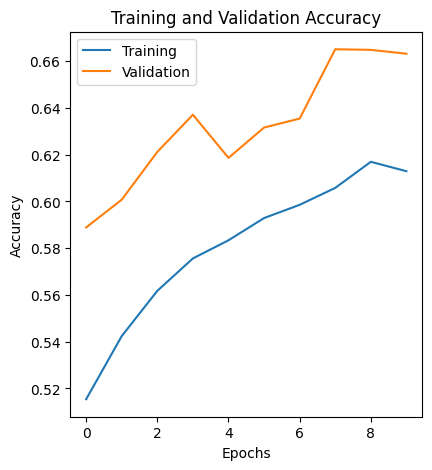

In [57]:
num_epochs=10
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accs, label='Training')
plt.plot(range(num_epochs), val_accs, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

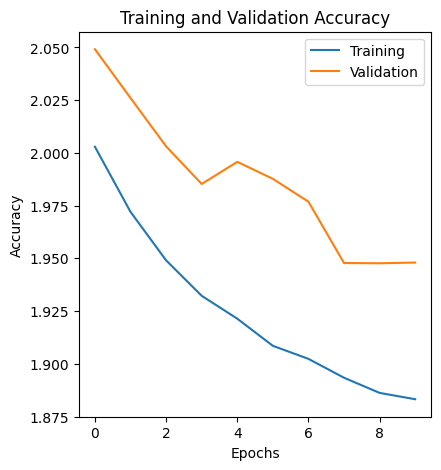

In [59]:
num_epochs=10
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training')
plt.plot(range(num_epochs), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

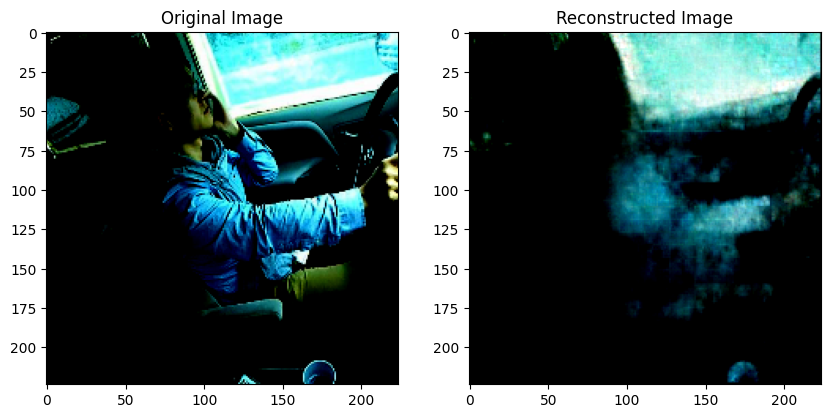

Original Label: 4
Predicted Label: 4


In [92]:
import matplotlib.pyplot as plt
import torch

autoencoder = autoencoder.to(device)
autoencoder.eval()

image, label = next(iter(val_loader))
image, label = image.to(device), label.to(device)

reconstructed_image = autoencoder(image)

reconstructed_image = reconstructed_image.cpu()

image = image.cpu().numpy()
reconstructed_image = reconstructed_image.detach().numpy()

image = np.transpose(image, (0, 2, 3, 1))
reconstructed_image = np.transpose(reconstructed_image, (0, 2, 3, 1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(image[0])
axes[0].set_title('Original Image')
axes[1].imshow(reconstructed_image[0])
axes[1].set_title('Reconstructed Image')
plt.show()

reconstructed_image = np.transpose(reconstructed_image, (0, 3, 1, 2))

reconstructed_image = torch.from_numpy(reconstructed_image).to(device)

reconstructed_image = F.interpolate(reconstructed_image, size=(224, 224), mode='bilinear', align_corners=False)
# Get the predicted label
with torch.no_grad():
    predicted_label = model(reconstructed_image)
    predicted_label = torch.argmax(predicted_label, dim=1).cpu().numpy()

# Convert the original label to a numpy array
original_label = label.cpu().numpy()

print(f"Original Label: {original_label[0]}")
print(f"Predicted Label: {predicted_label[0]}")